In [1]:


import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# Flatten images for logistic regression (28x28 -> 784)
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

# For GAN, we normalize to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_gan = scaler.fit_transform(X_train_flat)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Train shape: (60000, 28, 28) Test shape: (10000, 28, 28)


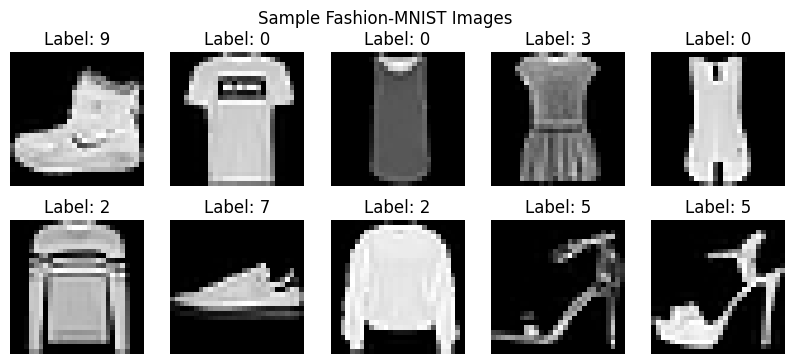

In [3]:
# Plot first 10 samples
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap="gray")
    ax.set_title(f"Label: {y_train[i]}")
    ax.axis("off")
plt.suptitle("Sample Fashion-MNIST Images")
plt.show()

Logistic Regression Accuracy: 0.8436

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80      1000
           1       0.97      0.96      0.96      1000
           2       0.72      0.74      0.73      1000
           3       0.83      0.86      0.84      1000
           4       0.74      0.77      0.75      1000
           5       0.95      0.92      0.93      1000
           6       0.62      0.57      0.60      1000
           7       0.91      0.94      0.93      1000
           8       0.93      0.94      0.93      1000
           9       0.95      0.95      0.95      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



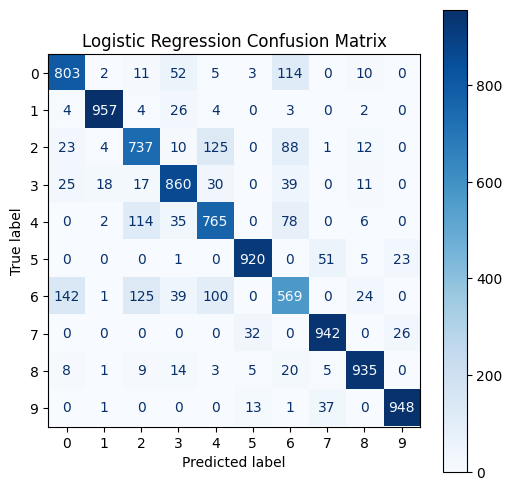

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Flatten and normalize for Logistic Regression
X_train_flat = X_train.reshape(-1, 28*28) / 255.0
X_test_flat = X_test.reshape(-1, 28*28) / 255.0

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_flat, y_train)

# Predictions
y_pred = lr_model.predict(X_test_flat)

# Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

Step 200/1000 | D loss: 0.9417 | G loss: 0.6177
Step 400/1000 | D loss: 0.8051 | G loss: 0.6777
Step 600/1000 | D loss: 0.7501 | G loss: 0.7141
Step 800/1000 | D loss: 0.7183 | G loss: 0.7404
Step 1000/1000 | D loss: 0.6805 | G loss: 0.7700


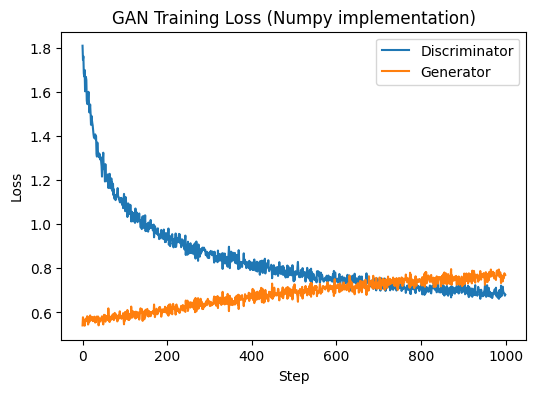

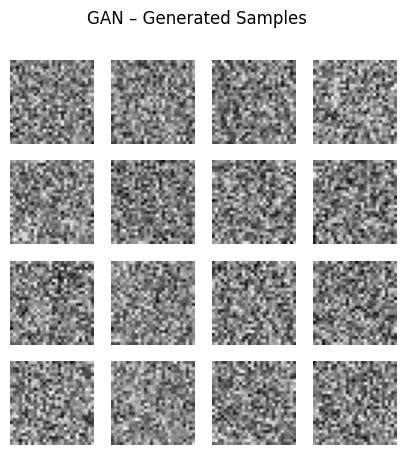

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

img_side = 28
flat_dim = img_side * img_side

X_flat = X_train.reshape(-1, flat_dim).astype("float32")

# Scale pixels from [0, 255] -> [-1, 1]
scaler = MinMaxScaler(feature_range=(-1.0, 1.0))
X_gan = scaler.fit_transform(X_flat)

latent_dim   = 100
gen_hidden   = 128
disc_hidden  = 128
batch_size   = 128
steps        = 1000
learning_rate = 2e-4
eps = 1e-8

rng = np.random.default_rng(42)

def xavier_init(in_dim, out_dim):
    """Xavier/Glorot initialization."""
    limit = np.sqrt(6.0 / (in_dim + out_dim))
    return rng.uniform(-limit, limit, size=(in_dim, out_dim))

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def leaky_relu(x, alpha=0.2):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_grad(x, alpha=0.2):
    grad = np.ones_like(x)
    grad[x < 0] = alpha
    return grad


G = {
    "W1": xavier_init(latent_dim, gen_hidden),
    "b1": np.zeros(gen_hidden),
    "W2": xavier_init(gen_hidden, flat_dim),
    "b2": np.zeros(flat_dim),
}

# Discriminator: image -> hidden -> prob(real)
D = {
    "W1": xavier_init(flat_dim, disc_hidden),
    "b1": np.zeros(disc_hidden),
    "W2": xavier_init(disc_hidden, 1),
    "b2": np.zeros(1),
}

def generator_forward(z, G):
    h_pre = z @ G["W1"] + G["b1"]
    h = leaky_relu(h_pre)
    img_logits = h @ G["W2"] + G["b2"]
    img_out = np.tanh(img_logits)  # keep images in [-1, 1]
    cache = (z, h_pre, h, img_logits, img_out)
    return img_out, cache

def discriminator_forward(x, D):
    h_pre = x @ D["W1"] + D["b1"]
    h = leaky_relu(h_pre)
    logits = h @ D["W2"] + D["b2"]
    prob = sigmoid(logits)
    cache = (x, h_pre, h, logits, prob)
    return prob, cache

disc_losses = []
gen_losses  = []

for step in range(1, steps + 1):
    # ---- Sample real data ----
    idx = rng.choice(len(X_gan), size=batch_size, replace=False)
    real_batch = X_gan[idx]

    # ---- Generate fake data ----
    z = rng.normal(0.0, 1.0, size=(batch_size, latent_dim))
    fake_batch, g_cache = generator_forward(z, G)

    # ---- Discriminator forward for real & fake ----
    d_real, d_cache_real = discriminator_forward(real_batch, D)
    d_fake, d_cache_fake = discriminator_forward(fake_batch, D)

    # ---- Losses ----
    # BCE loss: -[y log p + (1-y) log(1-p)]
    d_loss_real = -np.mean(np.log(d_real + eps))
    d_loss_fake = -np.mean(np.log(1.0 - d_fake + eps))
    d_loss = d_loss_real + d_loss_fake

    g_loss = -np.mean(np.log(d_fake + eps))

    disc_losses.append(d_loss)
    gen_losses.append(g_loss)

    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))

    # dL/dlogits = (p - y)/N for BCE with sigmoid
    x_real, hpre_real, h_real, logits_real, p_real = d_cache_real
    x_fake, hpre_fake, h_fake, logits_fake, p_fake = d_cache_fake

    delta_real = (p_real - y_real) / batch_size
    delta_fake = (p_fake - y_fake) / batch_size

    # Gradients for W2, b2
    grad_W2_D = h_real.T @ delta_real + h_fake.T @ delta_fake
    grad_b2_D = np.sum(delta_real + delta_fake, axis=0)

    # Back to hidden layer
    dh_real = delta_real @ D["W2"].T * leaky_relu_grad(hpre_real)
    dh_fake = delta_fake @ D["W2"].T * leaky_relu_grad(hpre_fake)

    grad_W1_D = x_real.T @ dh_real + x_fake.T @ dh_fake
    grad_b1_D = np.sum(dh_real + dh_fake, axis=0)

    # Gradient step for D
    D["W2"] -= learning_rate * grad_W2_D
    D["b2"] -= learning_rate * grad_b2_D
    D["W1"] -= learning_rate * grad_W1_D
    D["b1"] -= learning_rate * grad_b1_D


    z_in, g_hpre, g_h, g_logits, g_out = g_cache

    delta_g_disc = (p_fake - 1.0) / batch_size  # dL/d logits_fake

    # back through discriminator first layer
    dh_fake_for_G = delta_g_disc @ D["W2"].T * leaky_relu_grad(hpre_fake)

    # back to fake image (input of D)
    d_img = dh_fake_for_G @ D["W1"].T          # dL/d(fake_batch)

    # back through generator tanh
    d_g_logits = d_img * (1.0 - np.tanh(g_logits) ** 2)

    grad_W2_G = g_h.T @ d_g_logits
    grad_b2_G = np.sum(d_g_logits, axis=0)

    dh_G = d_g_logits @ G["W2"].T * leaky_relu_grad(g_hpre)
    grad_W1_G = z_in.T @ dh_G
    grad_b1_G = np.sum(dh_G, axis=0)

    # Gradient step for G
    G["W2"] -= learning_rate * grad_W2_G
    G["b2"] -= learning_rate * grad_b2_G
    G["W1"] -= learning_rate * grad_W1_G
    G["b1"] -= learning_rate * grad_b1_G

    if step % 200 == 0:
        print(f"Step {step}/{steps} | D loss: {d_loss:.4f} | G loss: {g_loss:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(disc_losses, label="Discriminator")
plt.plot(gen_losses, label="Generator")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("GAN Training Loss (Numpy implementation)")
plt.legend()
plt.show()


z_vis = rng.normal(0.0, 1.0, size=(16, latent_dim))
samples, _ = generator_forward(z_vis, G)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(samples[i].reshape(img_side, img_side), cmap="gray")
    ax.axis("off")
plt.suptitle("GAN – Generated Samples")
plt.show()


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Flatten 28x28 → 784 and normalize to [0,1]
X_train_flat = (X_train.reshape(-1, 28 * 28)).astype("float32") / 255.0
X_test_flat  = (X_test.reshape(-1, 28 * 28)).astype("float32") / 255.0

print(f"Training set shape: {X_train_flat.shape}")
print(f"Test set shape    : {X_test_flat.shape}")

# Use a smaller slice for fast experiments
train_size = 20_000
test_size  = 2_000

X_train_sub = X_train_flat[:train_size]
y_train_sub = y_train[:train_size]

X_test_sub = X_test_flat[:test_size]
y_test_sub = y_test[:test_size]


Training set shape: (60000, 784)
Test set shape    : (10000, 784)


In [9]:

svm_model = SVC(kernel="rbf", gamma="scale")   # default RBF setup
svm_model.fit(X_train_sub, y_train_sub)

svm_preds = svm_model.predict(X_test_sub)
svm_acc = accuracy_score(y_test_sub, svm_preds)
print(f"SVM (RBF) accuracy on subset: {svm_acc:.4f}")

# -----------------------------
# Decision Tree classifier
# -----------------------------
tree_model = DecisionTreeClassifier(max_depth=20, random_state=42)
tree_model.fit(X_train_sub, y_train_sub)

tree_preds = tree_model.predict(X_test_sub)
tree_acc = accuracy_score(y_test_sub, tree_preds)
print(f"Decision Tree accuracy on subset: {tree_acc:.4f}")


SVM (RBF) accuracy on subset: 0.8745
Decision Tree accuracy on subset: 0.7655


LogReg (L2) accuracy on 5k subset: 0.819
LogReg (L1) accuracy on 5k subset: 0.822


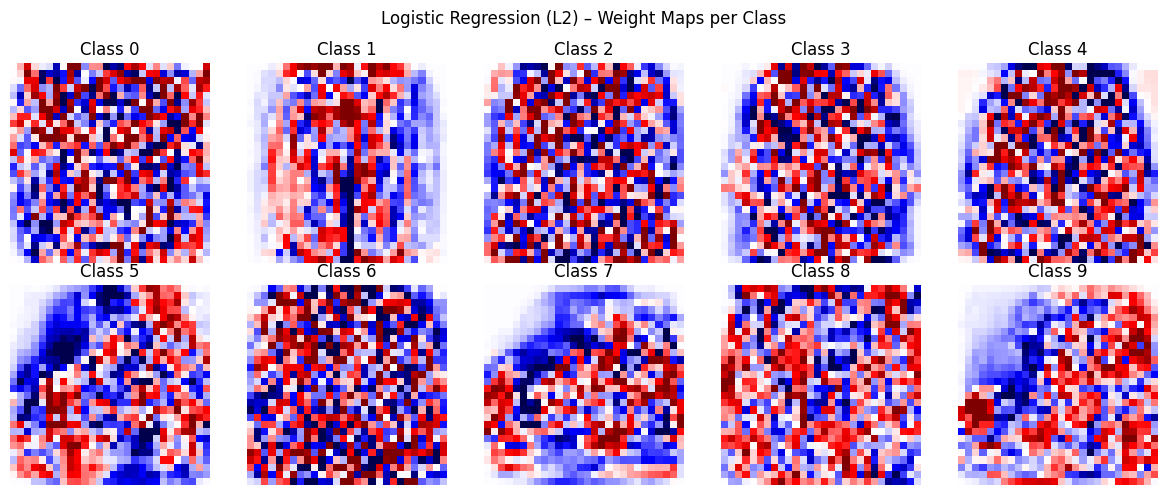

In [10]:
import warnings
warnings.filterwarnings("ignore")

small_train_size = 5_000
small_test_size  = 1_000

X_lr_train = X_train_flat[:small_train_size]
y_lr_train = y_train[:small_train_size]

X_lr_test = X_test_flat[:small_test_size]
y_lr_test = y_test[:small_test_size]

# L2-regularized logistic regression
logreg_l2 = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000,
    multi_class="auto"
)
logreg_l2.fit(X_lr_train, y_lr_train)
l2_preds = logreg_l2.predict(X_lr_test)
print("LogReg (L2) accuracy on 5k subset:", accuracy_score(y_lr_test, l2_preds))

# L1-regularized logistic regression
logreg_l1 = LogisticRegression(
    penalty="l1",
    solver="saga",     # supports L1
    max_iter=1000,
    multi_class="auto"
)
logreg_l1.fit(X_lr_train, y_lr_train)
l1_preds = logreg_l1.predict(X_lr_test)
print("LogReg (L1) accuracy on 5k subset:", accuracy_score(y_lr_test, l1_preds))


fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for class_idx, ax in enumerate(axes.ravel()):
    # each row in coef_ corresponds to one class
    weight_vector = logreg_l2.coef_[class_idx].reshape(28, 28)
    im = ax.imshow(weight_vector, cmap="seismic", vmin=-0.5, vmax=0.5)
    ax.set_title(f"Class {class_idx}")
    ax.axis("off")

plt.suptitle("Logistic Regression (L2) – Weight Maps per Class")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.model_selection import cross_val_score

cv_train_size = 10_000
X_cv = X_train_flat[:cv_train_size]
y_cv = y_train[:cv_train_size]

logreg_cv = LogisticRegression(
    max_iter=300,
    solver="lbfgs",
    multi_class="auto"
)

cv_scores = cross_val_score(logreg_cv, X_cv, y_cv, cv=5)

print(f"5-fold CV mean accuracy: {cv_scores.mean():.4f}")
print(f"5-fold CV std deviation: {cv_scores.std():.4f}")


5-fold CV mean accuracy: 0.8290
5-fold CV std deviation: 0.0099


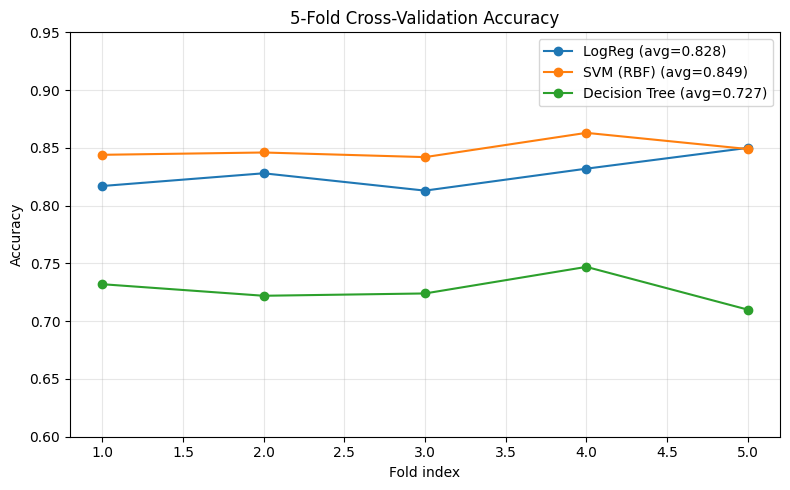

In [12]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

# Use a moderate subset so CV runs in reasonable time
n_samples_cv = 5_000
X_cv_small = X_train_flat[:n_samples_cv]
y_cv_small = y_train[:n_samples_cv]

# Define models to compare
cv_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver="lbfgs"),
    "SVM (RBF)": SVC(kernel="rbf", gamma="scale"),
    "Decision Tree": DecisionTreeClassifier(max_depth=20, random_state=42),
}

# 5-fold cross validation with shuffling
kf = KFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(8, 5))

for model_name, clf in cv_models.items():
    fold_scores = cross_val_score(clf, X_cv_small, y_cv_small, cv=kf)
    folds = np.arange(1, len(fold_scores) + 1)
    plt.plot(
        folds,
        fold_scores,
        marker="o",
        linestyle="-",
        label=f"{model_name} (avg={fold_scores.mean():.3f})"
    )

plt.title("5-Fold Cross-Validation Accuracy")
plt.xlabel("Fold index")
plt.ylabel("Accuracy")
plt.ylim(0.60, 0.95)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


Step 500/5000 | D loss: 0.4846 | G loss: 1.6724
Step 1000/5000 | D loss: 0.3688 | G loss: 1.7630
Step 1500/5000 | D loss: 0.4035 | G loss: 1.7661
Step 2000/5000 | D loss: 0.4349 | G loss: 1.7131
Step 2500/5000 | D loss: 0.4569 | G loss: 1.7012
Step 3000/5000 | D loss: 0.4434 | G loss: 1.6277
Step 3500/5000 | D loss: 0.4999 | G loss: 1.5813
Step 4000/5000 | D loss: 0.4956 | G loss: 1.5642
Step 4500/5000 | D loss: 0.4996 | G loss: 1.7075
Step 5000/5000 | D loss: 0.4458 | G loss: 1.7048


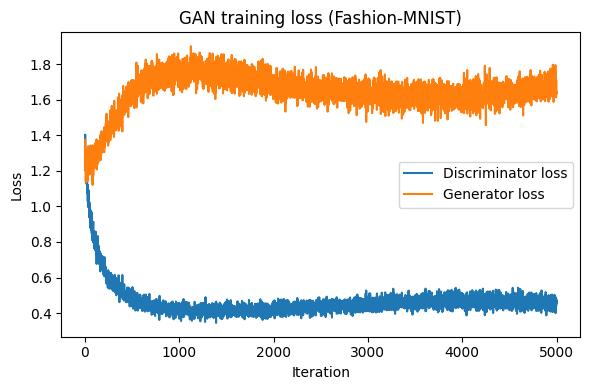

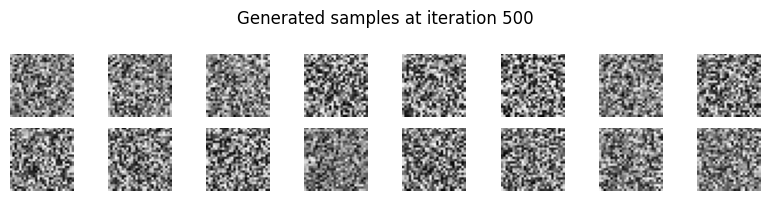

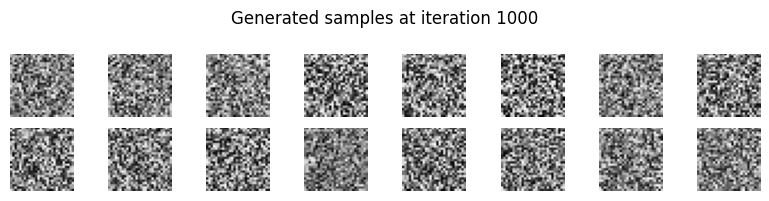

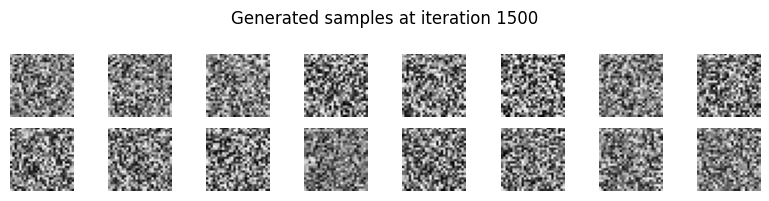

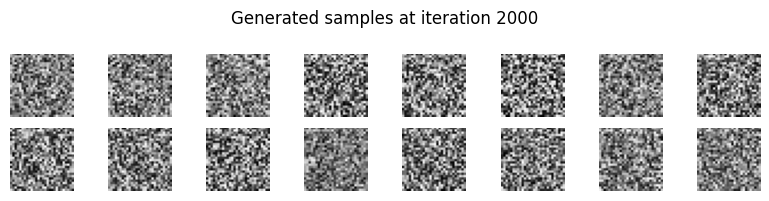

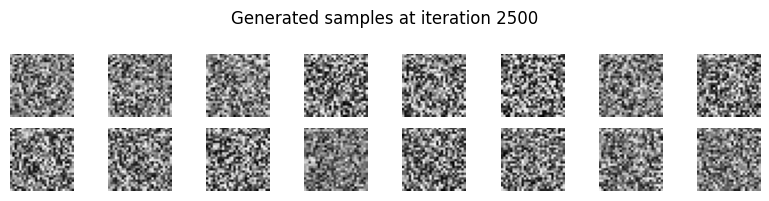

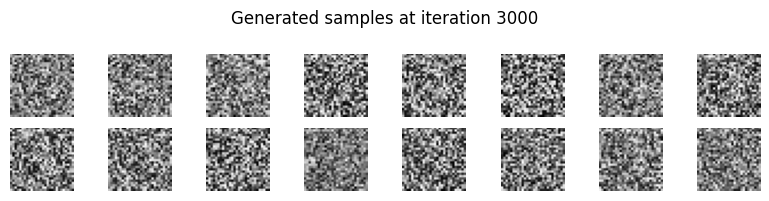

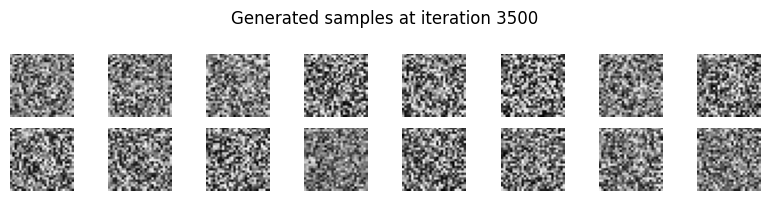

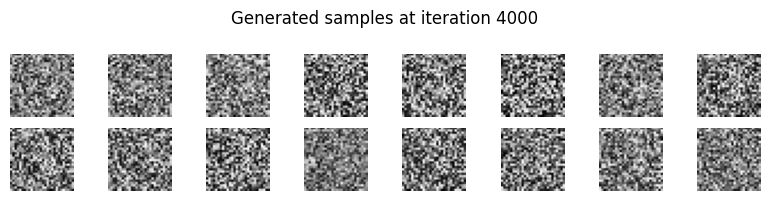

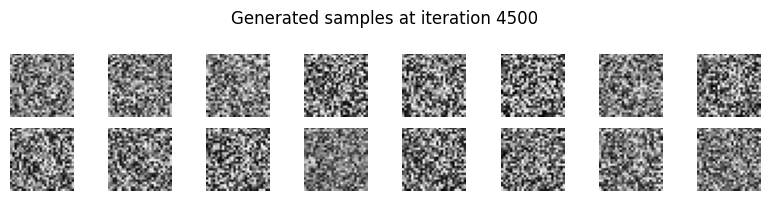

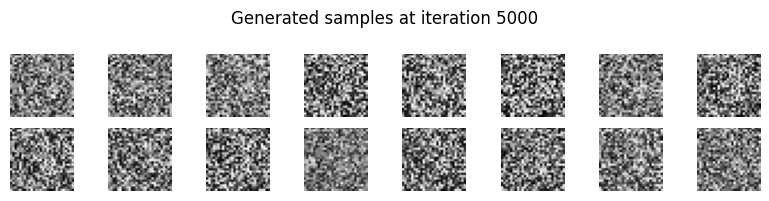


=== Unstable training demo with aggressive learning rates ===
[Unstable] step 200/1000 | D: 0.4789 | G: 1.7247
[Unstable] step 400/1000 | D: 0.4359 | G: 1.6837
[Unstable] step 600/1000 | D: 0.4503 | G: 1.6558
[Unstable] step 800/1000 | D: 0.4126 | G: 1.6177
[Unstable] step 1000/1000 | D: 0.4118 | G: 1.7113


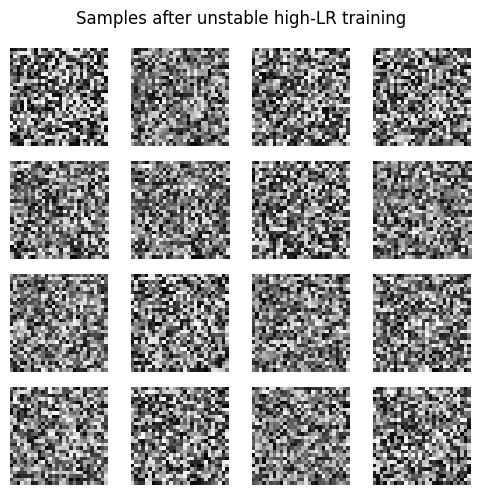

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.datasets import fashion_mnist


(X_train_raw, _), _ = fashion_mnist.load_data()

n_pixels = 28 * 28
X_train_vec = X_train_raw.reshape(-1, n_pixels).astype("float32")

# Rescale from [0, 255] → [-1, 1] to match tanh output
scaler_gan = MinMaxScaler(feature_range=(-1.0, 1.0))
X_gan_data = scaler_gan.fit_transform(X_train_vec)


latent_dim = 100
hidden_dim = 128
batch_size = 128
train_steps = 5_000

# Use slightly different learning rates for D and G
lr_disc = 2e-4
lr_gen = 1e-4

rng = np.random.default_rng(42)

def init_normal(shape, std=0.1):
    return rng.normal(loc=0.0, scale=std, size=shape)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def leaky_relu(x, alpha=0.2):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_grad(x, alpha=0.2):
    grad = np.ones_like(x)
    grad[x < 0] = alpha
    return grad

# -----------------------------
# Parameter initialization
# -----------------------------
# Generator: z → h1 → h2 → image
Wg1, bg1 = init_normal((latent_dim, hidden_dim)), np.zeros(hidden_dim)
Wg2, bg2 = init_normal((hidden_dim, hidden_dim)), np.zeros(hidden_dim)
Wg3, bg3 = init_normal((hidden_dim, n_pixels)), np.zeros(n_pixels)

# Discriminator: image → h1 → h2 → probability
Wd1, bd1 = init_normal((n_pixels, hidden_dim)), np.zeros(hidden_dim)
Wd2, bd2 = init_normal((hidden_dim, hidden_dim)), np.zeros(hidden_dim)
Wd3, bd3 = init_normal((hidden_dim, 1)), np.zeros(1)

# -----------------------------
# Training loop
# -----------------------------
disc_loss_history = []
gen_loss_history = []

# store generated samples at a few checkpoints
generated_checkpoints = {}
fixed_noise = rng.normal(0.0, 1.0, size=(16, latent_dim))

for step in range(1, train_steps + 1):
    # ----- sample a minibatch of real data -----
    idx = rng.choice(len(X_gan_data), size=batch_size, replace=False)
    real_batch = X_gan_data[idx]

    # ----- forward pass: Generator -----
    z = rng.normal(0.0, 1.0, size=(batch_size, latent_dim))
    g_h1_pre = z @ Wg1 + bg1
    g_h1 = leaky_relu(g_h1_pre)
    g_h2_pre = g_h1 @ Wg2 + bg2
    g_h2 = leaky_relu(g_h2_pre)
    g_logits = g_h2 @ Wg3 + bg3
    fake_batch = np.tanh(g_logits)

    # ----- forward pass: Discriminator on real and fake -----
    # real
    d1_real_pre = real_batch @ Wd1 + bd1
    d1_real = leaky_relu(d1_real_pre)
    d2_real_pre = d1_real @ Wd2 + bd2
    d2_real = leaky_relu(d2_real_pre)
    d_real_logits = d2_real @ Wd3 + bd3
    d_real_prob = sigmoid(d_real_logits)

    # fake
    d1_fake_pre = fake_batch @ Wd1 + bd1
    d1_fake = leaky_relu(d1_fake_pre)
    d2_fake_pre = d1_fake @ Wd2 + bd2
    d2_fake = leaky_relu(d2_fake_pre)
    d_fake_logits = d2_fake @ Wd3 + bd3
    d_fake_prob = sigmoid(d_fake_logits)

    # ----- losses (with label smoothing for real) -----
    smooth_real = rng.uniform(0.8, 1.0, size=(batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    # discriminator loss: real + fake
    d_loss = -(
        np.mean(np.log(d_real_prob + 1e-8)) +
        np.mean(np.log(1.0 - d_fake_prob + 1e-8))
    )

    # generator loss: wants discriminator to output 1 for fakes
    g_loss = -np.mean(np.log(d_fake_prob + 1e-8))

    disc_loss_history.append(d_loss)
    gen_loss_history.append(g_loss)


    d_delta_real = (d_real_prob - smooth_real) / batch_size
    d_delta_fake = (d_fake_prob - fake_labels) / batch_size

    # grads for Wd3, bd3
    grad_Wd3 = d2_real.T @ d_delta_real + d2_fake.T @ d_delta_fake
    grad_bd3 = np.sum(d_delta_real + d_delta_fake, axis=0)

    # back to second hidden layer
    d_d2_real = (d_delta_real @ Wd3.T) * leaky_relu_grad(d2_real_pre)
    d_d2_fake = (d_delta_fake @ Wd3.T) * leaky_relu_grad(d2_fake_pre)

    grad_Wd2 = d1_real.T @ d_d2_real + d1_fake.T @ d_d2_fake
    grad_bd2 = np.sum(d_d2_real + d_d2_fake, axis=0)

    # back to first hidden layer
    d_d1_real = (d_d2_real @ Wd2.T) * leaky_relu_grad(d1_real_pre)
    d_d1_fake = (d_d2_fake @ Wd2.T) * leaky_relu_grad(d1_fake_pre)

    grad_Wd1 = real_batch.T @ d_d1_real + fake_batch.T @ d_d1_fake
    grad_bd1 = np.sum(d_d1_real + d_d1_fake, axis=0)

    # gradient step (discriminator)
    Wd3 -= lr_disc * grad_Wd3
    bd3 -= lr_disc * grad_bd3
    Wd2 -= lr_disc * grad_Wd2
    bd2 -= lr_disc * grad_bd2
    Wd1 -= lr_disc * grad_Wd1
    bd1 -= lr_disc * grad_bd1


    target_gen = np.ones((batch_size, 1))
    g_delta_disc = (d_fake_prob - target_gen) / batch_size  # dL/d(logits_fake)

    # back through discriminator into fake images
    d_d2_fake_for_g = (g_delta_disc @ Wd3.T) * leaky_relu_grad(d2_fake_pre)
    d_d1_fake_for_g = (d_d2_fake_for_g @ Wd2.T) * leaky_relu_grad(d1_fake_pre)
    d_fake_imgs = d_d1_fake_for_g @ Wd1.T   # dL/d(fake_batch)

    # back through tanh in generator output
    d_g_logits = d_fake_imgs * (1.0 - np.tanh(g_logits) ** 2)

    grad_Wg3 = g_h2.T @ d_g_logits
    grad_bg3 = np.sum(d_g_logits, axis=0)

    d_g_h2 = (d_g_logits @ Wg3.T) * leaky_relu_grad(g_h2_pre)
    grad_Wg2 = g_h1.T @ d_g_h2
    grad_bg2 = np.sum(d_g_h2, axis=0)

    d_g_h1 = (d_g_h2 @ Wg2.T) * leaky_relu_grad(g_h1_pre)
    grad_Wg1 = z.T @ d_g_h1
    grad_bg1 = np.sum(d_g_h1, axis=0)

    # gradient step (generator)
    Wg3 -= lr_gen * grad_Wg3
    bg3 -= lr_gen * grad_bg3
    Wg2 -= lr_gen * grad_Wg2
    bg2 -= lr_gen * grad_bg2
    Wg1 -= lr_gen * grad_Wg1
    bg1 -= lr_gen * grad_bg1

    if step % 500 == 0:
        with np.errstate(over="ignore"):
            h1 = leaky_relu(fixed_noise @ Wg1 + bg1)
            h2 = leaky_relu(h1 @ Wg2 + bg2)
            g_out = np.tanh(h2 @ Wg3 + bg3)
        generated_checkpoints[step] = g_out
        print(f"Step {step}/{train_steps} | D loss: {d_loss:.4f} | G loss: {g_loss:.4f}")


plt.figure(figsize=(6, 4))
plt.plot(disc_loss_history, label="Discriminator loss")
plt.plot(gen_loss_history, label="Generator loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("GAN training loss (Fashion-MNIST)")
plt.legend()
plt.tight_layout()
plt.show()


for step, sample_batch in generated_checkpoints.items():
    fig, axes = plt.subplots(2, 8, figsize=(8, 2))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(sample_batch[i].reshape(28, 28), cmap="gray")
        ax.axis("off")
    plt.suptitle(f"Generated samples at iteration {step}")
    plt.tight_layout()
    plt.show()
print("\n=== Unstable training demo with aggressive learning rates ===")

unstable_lr_d = 1e-2
unstable_lr_g = 1e-2
unstable_batch = 32
unstable_steps = 1_000

disc_loss_unstable = []
gen_loss_unstable = []

for step in range(1, unstable_steps + 1):
    idx = rng.choice(len(X_gan_data), size=unstable_batch, replace=False)
    real_batch = X_gan_data[idx]

    # forward generator
    z = rng.normal(0.0, 1.0, size=(unstable_batch, latent_dim))
    g_h1_pre = z @ Wg1 + bg1
    g_h1 = leaky_relu(g_h1_pre)
    g_h2_pre = g_h1 @ Wg2 + bg2
    g_h2 = leaky_relu(g_h2_pre)
    g_logits = g_h2 @ Wg3 + bg3
    fake_batch = np.tanh(g_logits)

    # discriminator on real and fake
    d1_real_pre = real_batch @ Wd1 + bd1
    d1_real = leaky_relu(d1_real_pre)
    d2_real_pre = d1_real @ Wd2 + bd2
    d2_real = leaky_relu(d2_real_pre)
    d_real_logits = d2_real @ Wd3 + bd3
    d_real_prob = sigmoid(d_real_logits)

    d1_fake_pre = fake_batch @ Wd1 + bd1
    d1_fake = leaky_relu(d1_fake_pre)
    d2_fake_pre = d1_fake @ Wd2 + bd2
    d2_fake = leaky_relu(d2_fake_pre)
    d_fake_logits = d2_fake @ Wd3 + bd3
    d_fake_prob = sigmoid(d_fake_logits)

    # basic (no smoothing) labels here
    y_real = np.ones((unstable_batch, 1))
    y_fake = np.zeros((unstable_batch, 1))

    d_loss = -(
        np.mean(np.log(d_real_prob + 1e-8)) +
        np.mean(np.log(1.0 - d_fake_prob + 1e-8))
    )
    g_loss = -np.mean(np.log(d_fake_prob + 1e-8))

    disc_loss_unstable.append(d_loss)
    gen_loss_unstable.append(g_loss)

    if step % 200 == 0:
        print(f"[Unstable] step {step}/{unstable_steps} | D: {d_loss:.4f} | G: {g_loss:.4f}")

# visualize sample set after unstable phase
z_vis = rng.normal(0.0, 1.0, size=(16, latent_dim))
h1 = leaky_relu(z_vis @ Wg1 + bg1)
h2 = leaky_relu(h1 @ Wg2 + bg2)
unstable_samples = np.tanh(h2 @ Wg3 + bg3)

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(unstable_samples[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
plt.suptitle("Samples after unstable high-LR training")
plt.tight_layout()
plt.show()


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


n_synth = 5_000

# Sample noise and push it through the trained generator
z_synth = rng.normal(0.0, 1.0, size=(n_synth, latent_dim))

h1_pre = z_synth @ Wg1 + bg1
h1 = leaky_relu(h1_pre)
h2_pre = h1 @ Wg2 + bg2
h2 = leaky_relu(h2_pre)
img_logits = h2 @ Wg3 + bg3
X_synth = np.tanh(img_logits)  # synthetic images in [-1, 1]

# The GAN is unconditional → no true labels; use random labels just to probe separability
pseudo_labels = rng.integers(low=0, high=10, size=n_synth)

logreg_synth = LogisticRegression(
    max_iter=1000,
    solver="lbfgs",
    multi_class="auto"
)
logreg_synth.fit(X_synth, pseudo_labels)

# Evaluate this synthetic-trained classifier on real Fashion-MNIST test images
y_pred_test = logreg_synth.predict(X_test_flat)
print("Logistic Regression trained on GAN synthetic data, tested on real data")
print("Test accuracy:", accuracy_score(y_test, y_pred_test))

Logistic Regression trained on GAN synthetic data, tested on real data
Test accuracy: 0.107


In [18]:
# after stable GAN training finishes, BEFORE any unstable / collapse experiment
G_snap = {
    "W1": Wg1.copy(),
    "b1": bg1.copy(),
    "W2": Wg2.copy(),
    "b2": bg2.copy(),
    "W3": Wg3.copy(),
    "b3": bg3.copy(),
}


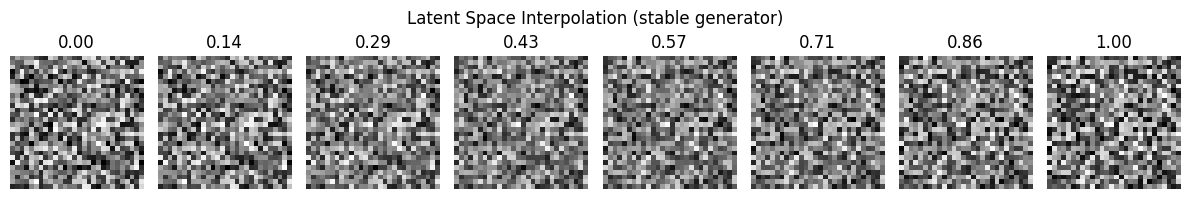

In [21]:
def generator_forward_with_snapshot(z, G):
    h1_pre = z @ G["W1"] + G["b1"]
    h1 = leaky_relu(h1_pre)
    h2_pre = h1 @ G["W2"] + G["b2"]
    h2 = leaky_relu(h2_pre)
    logits = h2 @ G["W3"] + G["b3"]
    x = np.tanh(logits)
    return x

# pick two random latent codes
z_start = rng.normal(0.0, 1.0, size=(1, latent_dim))
z_end   = rng.normal(0.0, 1.0, size=(1, latent_dim))

n_steps = 8
alphas = np.linspace(0.0, 1.0, n_steps)

images_interp = []

for a in alphas:
    z_mix = (1.0 - a) * z_start + a * z_end
    x_mix = generator_forward_with_snapshot(z_mix, G_snap)
    images_interp.append(x_mix)

images_interp = np.vstack(images_interp)

fig, axes = plt.subplots(1, n_steps, figsize=(12, 2))
for i, ax in enumerate(axes):
    ax.imshow(images_interp[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title(f"{alphas[i]:.2f}")
plt.suptitle("Latent Space Interpolation (stable generator)")
plt.tight_layout()
plt.show()